In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
import plotly.express as px
import numpy as np
import gmaps
import gmaps.datasets 
from folium import Map
from folium.plugins import HeatMap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

In [2]:
'''Because of the size of the dataset we must store the dataset in googlebigquery and 
then take the data as needed for our analysis'''

'Because of the size of the dataset we must store the dataset in googlebigquery and \nthen take the data as needed for our analysis'

In [122]:
#Set environment variables for your notebook
import pyarrow 
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/amandamanfredo/Downloads/liquor_data.json'
#Imports google cloud client library and initiates BQ service
from google.cloud import bigquery
bigquery_client = bigquery.Client()
#Write Query on BQ
QUERY = """
SELECT *
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date>='2019-01-01' AND date<'2020-02-01'
LIMIT 250000
  
  """
#Run the query and write result to a pandas data frame
Query_Results = bigquery_client.query(QUERY)
df = Query_Results.to_dataframe()
#View top few rows of result
df.head()

invoice_and_item_number        date store_number  \
0         INV-24649100063  2020-01-17         3963   
1         INV-20224300035  2019-06-26         2619   
2         INV-21373700072  2019-08-20         2621   
3         INV-21564200066  2019-08-28         5315   
4         INV-20109700059  2019-06-20         5102   

                          store_name                address             city  \
0   Tobacco Hut #14 / Council Bluffs        1925 W Broadway   Council Bluffs   
1      Hy-Vee Wine and Spirits / WDM          1725  74th St  West Des Moines   
2  Hy-Vee Food Store #3 / Sioux City         3301 Gordon Dr       Sioux City   
3  Brother's Market Wine and Spirits  110 South Main Street        Sigourney   
4                     Wilkie Liquors        724 1st  St  SE     Mount Vernon   

  zip_code                        store_location county_number      county  \
0  51501.0          POINT (-95.873073 41.261866)            78  POTTAWATTA   
1    50266          POINT (-93.808855 41.598515)            77        POLK   
2    51105          POINT (-96.364108 42.487752)            97    WOODBURY   
3    52591  POINT (-92.20510500000002 41.333293)            54      KEOKUK   
4    52314          POINT (-91.410401 41.918328)            57        LINN   

    category       category_name vendor_number               vendor_name  \
0  1081100.0     Coffee Liqueurs         370.0         PERNOD RICARD USA   
1       None                None           306  MISSISSIPPI RIVER DISTIL   
2  1041300.0  American Sloe Gins         434.0                 LUXCO INC   
3  1081100.0     Coffee Liqueurs          65.0           Jim Beam Brands   
4  1081500.0          Triple Sec           434                 LUXCO INC   

  item_number       item_description  pack  bottle_volume_ml  \
0       67527          Kahlua Coffee    12              1000   
1       40569     Pride of the Wapsi    12               375   
2       33717     Paramount Sloe Gin    12              1000   
3       67557  Kamora Coffee Liqueur    12              1000   
4       86507   Paramount Triple Sec    12              1000   

   state_bottle_cost  state_bottle_retail  bottles_sold  sale_dollars  \
0              15.15                22.73             2         45.46   
1               9.09                13.64             3         40.92   
2               5.42                 8.13             2         16.26   
3               8.39                12.59             2         25.18   
4               3.84                 5.76           300       1728.00   

   volume_sold_liters  volume_sold_gallons  
0                2.00                 0.52  
1                1.12                 0.29  
2                2.00                 0.52  
3                2.00                 0.52  
4              300.00                79.25

In [123]:
df.columns

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume_ml',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons'],
      dtype='object')

In [124]:
df['Profit_per_bottle']=df['state_bottle_retail']-df['state_bottle_cost']
df['Profit_per_sale']=df['Profit_per_bottle']*df['bottles_sold']
df.head(20)

invoice_and_item_number        date store_number  \
0          INV-24649100063  2020-01-17         3963   
1          INV-20224300035  2019-06-26         2619   
2          INV-21373700072  2019-08-20         2621   
3          INV-21564200066  2019-08-28         5315   
4          INV-20109700059  2019-06-20         5102   
5          INV-24441100088  2020-01-08         2601   
6          INV-24687600007  2020-01-21         2666   
7          INV-21078800001  2019-08-06         5402   
8          INV-24854800022  2020-01-28         5004   
9          INV-21419900026  2019-08-23         5831   
10         INV-20178900126  2019-06-24         2649   
11         INV-20236800003  2019-06-26         4462   
12         INV-24521500066  2020-01-13         2616   
13         INV-24365400009  2020-01-06         3952   
14         INV-24848400012  2020-01-28         4642   
15         INV-20029700068  2019-06-17         2576   
16         INV-21851000045  2019-09-11         5315   
17         INV-20094300001  2019-06-19         3477   
18         INV-21513200147  2019-08-27         2538   
19         INV-20464600043  2019-07-08         4320   

                                       store_name                   address  \
0                Tobacco Hut #14 / Council Bluffs           1925 W Broadway   
1                   Hy-Vee Wine and Spirits / WDM             1725  74th St   
2               Hy-Vee Food Store #3 / Sioux City            3301 Gordon Dr   
3               Brother's Market Wine and Spirits     110 South Main Street   
4                                  Wilkie Liquors           724 1st  St  SE   
5                   Hy-Vee Food Store / Fairfield  1300 West Burlington Ave   
6             Hy-Vee Food Store #2 / State Ankeny          2510 SW State St   
7                                     City Liquor      425 S Gilbert Street   
8                            Ida Grove Food Pride     200 Susan Lawrence Dr   
9      Casey's General Store #1828 / Webster City               1300 2nd St   
10                            Hy-Vee #3 / Dubuque             400 Locust St   
11                                      SHELTON'S             113 1st St NW   
12                 Hy-Vee Food and Drug / Clinton          901 South 4th St   
13                                  Lot-A-Spirits             3780 State St   
14  Liquor and Tobacco Outlet / Univ Ave Waterloo       2844 University Ave   
15           Hy-Vee Wine and Spirits / Storm Lake            1250 N Lake St   
16              Brother's Market Wine and Spirits     110 South Main Street   
17               Sam's Club 6472 / Council Bluffs     3221 Manawa Centre Dr   
18                Hy-Vee Food Store #3 / Waterloo          1422 Flammang Dr   
19                    Fareway Stores #470 / Perry                      None   

               city zip_code                         store_location  \
0    Council Bluffs  51501.0           POINT (-95.873073 41.261866)   
1   West Des Moines    50266           POINT (-93.808855 41.598515)   
2        Sioux City    51105           POINT (-96.364108 42.487752)   
3         Sigourney    52591   POINT (-92.20510500000002 41.333293)   
4      Mount Vernon    52314           POINT (-91.410401 41.918328)   
5         Fairfield  52556.0           POINT (-91.978702 41.006456)   
6            Ankeny  50023.0           POINT (-93.621824 41.705188)   
7         Iowa City    52240           POINT (-91.530225 41.656031)   
8         Ida Grove  51445.0                                   None   
9      Webster City    50595           POINT (-93.835789 42.469575)   
10          Dubuque    52001   POINT (-90.666497 42.49721900000001)   
11   Buffalo Center    50424           POINT (-93.947595 43.386755)   
12          Clinton  52732.0  POINT (-90.193204 41.836268000000004)   
13       Bettendorf  52722.0            POINT (-90.48065 41.529655)   
14         Waterloo  50701.0           POINT (-92.382928 42.498321)   
15       Storm Lake    50588   POINT (-95.200758 42

In [125]:
#getting an idea of the average profit per bottle
print('mean:',df['Profit_per_bottle'].mean())

#getting an idea of median profit since a few expensive/profitable bottles can skew mean
print('median:',df['Profit_per_bottle'].median())

#finding the max profit per bottle
df.loc[df['Profit_per_bottle'] == df['Profit_per_bottle'].max()] 

mean: 4.919890280002666
median: 4.0


invoice_and_item_number        date store_number          store_name  \
45594         INV-18238000001  2019-03-20         5298  DeWitt Travel Mart   

            address    city zip_code                store_location  \
45594  630, 6th Ave  DeWitt    52742  POINT (-90.538952 41.821779)   

      county_number   county   category       category_name vendor_number  \
45594            23  CLINTON  1012300.0  Single Malt Scotch           260   

           vendor_name item_number     item_description  pack  \
45594  DIAGEO AMERICAS      904595  HA Carsebridge 48YR     6   

       bottle_volume_ml  state_bottle_cost  state_bottle_retail  bottles_sold  \
45594               750             479.99               719.99             1   

       sale_dollars  volume_sold_liters  volume_sold_gallons  \
45594        719.99                0.75                 0.19   

       Profit_per_bottle  Profit_per_sale  
45594              240.0            240.0

array([[<AxesSubplot:title={'center':'Profit_per_bottle'}>]], dtype=object)

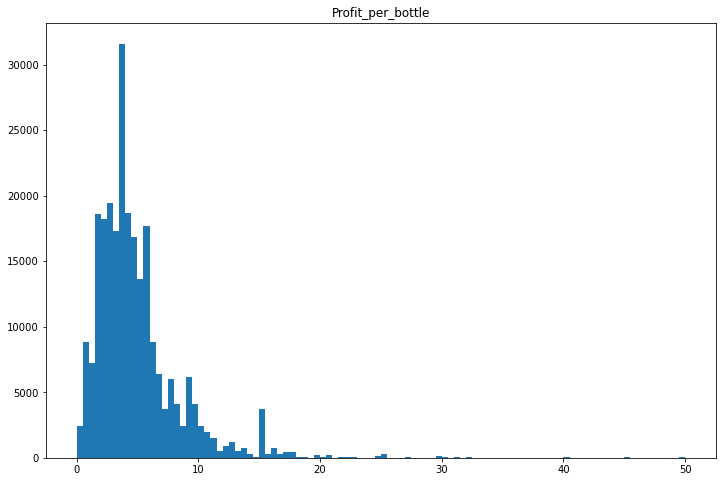

In [126]:
#seeing the distribution of profit per bottle
df.hist(column='Profit_per_bottle', bins=100, grid=False, figsize=(12,8),range=[0, 50])

In [127]:
df.isnull().sum()

invoice_and_item_number        0
date                           0
store_number                   0
store_name                     0
address                      461
city                         461
zip_code                     461
store_location             23006
county_number                461
county                       461
category                     653
category_name                653
vendor_number                  0
vendor_name                    0
item_number                    0
item_description               0
pack                           0
bottle_volume_ml               0
state_bottle_cost              0
state_bottle_retail            0
bottles_sold                   0
sale_dollars                   0
volume_sold_liters             0
volume_sold_gallons            0
Profit_per_bottle              0
Profit_per_sale                0
dtype: int64

In [128]:
df['category'].nunique()

40

# Exploring which categories of alcohol are more profitable on average

In [129]:
df['category_name'] = df['category_name'].str.lower()

In [130]:
best10 = df.groupby(['category_name'])['Profit_per_bottle'].mean().groupby(['category_name']).max().sort_values().groupby(['category_name']).sum().sort_values(ascending=False).reset_index()

best10_plot = px.bar(best10.head(10),x=best10['category_name'].head(10), y='Profit_per_bottle',color='Profit_per_bottle')
best10_plot.update_layout(
    title="10 Best Average Profit per Bottle Liquor Categories",
    xaxis_title="Category Name",
    yaxis_title="Average Profit per Bottle($)")
best10_plot.show()

# Exploring which categories of alcohol are least profitable

In [131]:
low10_plot = px.bar(best10.tail(10),x=best10['category_name'].tail(10), y='Profit_per_bottle',color='Profit_per_bottle')
low10_plot.update_layout(
    title="10 Lowest Profit Liquor Categories",
    xaxis_title="Category Name",
    yaxis_title="Average Profit per Bottle($)")
low10_plot.show()

# Exploring which counties have the highest profits overall 

In [132]:
#turning the county names to lowercase to prevent discrepancies
df['county'] = df['county'].str.lower()

In [133]:
bestcounty = df.groupby(['county'])['Profit_per_sale'].sum().groupby(['county']).max().sort_values().groupby(['county']).sum().sort_values(ascending=False).reset_index()

bestcounty_plot = px.bar(bestcounty.head(10),x=bestcounty['county'].head(10), y='Profit_per_sale',color='Profit_per_sale')
bestcounty_plot.update_layout(
    title="10 Best County Profit Liquor",
    xaxis_title="county",
    yaxis_title="Total Profits ($)")
bestcounty_plot.show()

# Comparing sales profits by city

In [134]:
df['city'] = df['city'].str.lower()

In [135]:
bestcity = df.groupby(['city'])['Profit_per_sale'].sum().groupby(['city']).max().sort_values().groupby(['city']).sum().sort_values(ascending=False).reset_index()

bestcity_plot = px.bar(bestcity.head(10),x=bestcity['city'].head(10), y='Profit_per_sale',color='Profit_per_sale')
bestcity_plot.update_layout(
    title="10 Best City for Profit Liquor Categories",
    xaxis_title="City",
    yaxis_title="Total Profits ($)")
bestcity_plot.show()

In [136]:
df['vendor_name'] = df['vendor_name'].str.lower()

In [137]:
bestvendors = df.groupby(['vendor_name'])['Profit_per_sale'].sum().groupby(['vendor_name']).max().sort_values().groupby(['vendor_name']).sum().sort_values(ascending=False).reset_index()

bestvendors_plot = px.bar(bestvendors.head(10),x=bestvendors['vendor_name'].head(10), y='Profit_per_sale',color='Profit_per_sale')
bestvendors_plot.update_layout(
    title="10 Best Vendors for Profit Liquor Categories",
    xaxis_title="Vendor",
    yaxis_title="Total Profits ($)")
bestvendors_plot.show()

# Creating a Heatmap of the locations of the liquor stores in Iowa

In [138]:
#First we need to clean up the store location column
df1=df
df1 = df1[df1['store_location'].notna()]

In [139]:
#Changing the column type to string so we can strip leading POINT
df1['store_location'] = df1.store_location.astype(str)

#stripping the non-latitude-longitude values from the column
df1['store_location'] = df1['store_location'].map(lambda x: x.lstrip('POINT (').rstrip(')'))

In [140]:
#creating latitude and longitude columns to use for our heatmap
df1[['Longitude','Latitude']] = df1['store_location'].str.split(' ', expand=True)

In [141]:
#folium requires the data to be float type

df1['Latitude'] = df1['Latitude'].str.replace(' ', '').astype(float)
df1['Longitude'] = df1['Longitude'].str.replace(' ', '').astype(float)

#dropping the original store location column since now it is repetitive
df1 = df1.drop('store_location', 1)

In [142]:
df1.head()

invoice_and_item_number        date store_number  \
0         INV-24649100063  2020-01-17         3963   
1         INV-20224300035  2019-06-26         2619   
2         INV-21373700072  2019-08-20         2621   
3         INV-21564200066  2019-08-28         5315   
4         INV-20109700059  2019-06-20         5102   

                          store_name                address             city  \
0   Tobacco Hut #14 / Council Bluffs        1925 W Broadway   council bluffs   
1      Hy-Vee Wine and Spirits / WDM          1725  74th St  west des moines   
2  Hy-Vee Food Store #3 / Sioux City         3301 Gordon Dr       sioux city   
3  Brother's Market Wine and Spirits  110 South Main Street        sigourney   
4                     Wilkie Liquors        724 1st  St  SE     mount vernon   

  zip_code county_number      county   category       category_name  \
0  51501.0            78  pottawatta  1081100.0     coffee liqueurs   
1    50266            77        polk       None                None   
2    51105            97    woodbury  1041300.0  american sloe gins   
3    52591            54      keokuk  1081100.0     coffee liqueurs   
4    52314            57        linn  1081500.0          triple sec   

  vendor_number               vendor_name item_number       item_description  \
0         370.0         pernod ricard usa       67527          Kahlua Coffee   
1           306  mississippi river distil       40569     Pride of the Wapsi   
2         434.0                 luxco inc       33717     Paramount Sloe Gin   
3          65.0           jim beam brands       67557  Kamora Coffee Liqueur   
4           434                 luxco inc       86507   Paramount Triple Sec   

   pack  bottle_volume_ml  state_bottle_cost  state_bottle_retail  \
0    12              1000              15.15                22.73   
1    12               375               9.09                13.64   
2    12              1000               5.42                 8.13   
3    12              1000               8.39                12.59   
4    12              1000               3.84                 5.76   

   bottles_sold  sale_dollars  volume_sold_liters  volume_sold_gallons  \
0             2         45.46                2.00                 0.52   
1             3         40.92                1.12                 0.29   
2             2         16.26                2.00                 0.52   
3             2         25.18                2.00                 0.52   
4           300       1728.00              300.00                79.25   

   Profit_per_bottle  Profit_per_sale  Longitude   Latitude  
0               7.58            15.16 -95.873073  41.261866  
1               4.55            13.65 -93.808855  41.598515  
2               2.71             5.42 -96.364108  42.487752  
3               4.20             8.40 -92.205105  41.333293  
4               1.92           576.00 -91.410401  41.918328

In [143]:
import folium
from IPython.display import display

mymap= folium.Map(location=[43.088341,-93.990256], zoom_start=8, )
mymap

In [144]:
hm_wide = HeatMap(
    list(zip(df1.Latitude.values, df1.Longitude.values)),
    min_opacity=0.2,
    radius=17, 
    blur=10, 
    max_zoom=1,
)

In [146]:
mymap.add_child(hm_wide)
#mymap.add_child(folium.ClickForMarker(popup='Potential Location'))

# Looking at time series data for the year 2019-2020

In [73]:
from dateutil.parser import parse 

In [75]:
#making a new dataframe I can make changes to
timedf=df

In [155]:
#finding the total sales profits each day

dailysales = timedf.groupby(['date'])['Profit_per_sale'].sum().reset_index()

#dailysales = dailysales.set_index('date')

#rename sum of profit per sale to profit per day
dailysales.rename({'Profit_per_sale': 'Profit_per_day'}, axis=1, inplace=True)
dailysales.head(20)

date  Profit_per_day
0   2019-01-02        30263.53
1   2019-01-03        37481.44
2   2019-01-04        42674.26
3   2019-01-07        44266.25
4   2019-01-08        39019.63
5   2019-01-09        34269.91
6   2019-01-10        40849.07
7   2019-01-11        19809.47
8   2019-01-14        35811.33
9   2019-01-15        33908.33
10  2019-01-16        37913.42
11  2019-01-17        30053.90
12  2019-01-18        30150.97
13  2019-01-22        44220.48
14  2019-01-23        30591.13
15  2019-01-24        48700.47
16  2019-01-25        29516.41
17  2019-01-28        53720.53
18  2019-01-29        35106.54
19  2019-01-30        31702.89

In [156]:
dailysales['date'].nunique()

286

<AxesSubplot:xlabel='date', ylabel='Profit_per_day'>

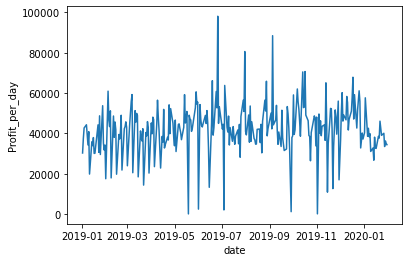

In [158]:
y=dailysales['Profit_per_day']
x=dailysales['date']
sns.lineplot(x,y)


In [159]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()

NameError: name 'sm' is not defined

In [ ]:
#products=pd.read_csv('Amanda/Iowa_Liquor_Products.csv')

In [ ]:
#products=products.drop(['List Date', 'Report Date','UPC','SCC'] , axis=1)

In [82]:
#Set environment variables for your notebook
import pyarrow 
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/amandamanfredo/Downloads/liquor_data.json'
#Imports google cloud client library and initiates BQ service
from google.cloud import bigquery
bigquery_client = bigquery.Client()
#Write Query on BQ
QUERY = """
SELECT *

FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE store_name LIKE '%Hy-Vee%'
LIMIT 50000
  
  """
#Run the query and write result to a pandas data frame
Query_Results = bigquery_client.query(QUERY)
hyv = Query_Results.to_dataframe()
#View top few rows of result
hyv.head()

invoice_and_item_number        date store_number  \
0         INV-37551200005  2021-06-16         2501   
1            S07679900036  2012-09-12         2596   
2            S21444800043  2014-09-25         2612   
3         INV-28344200023  2020-06-29         2628   
4            S08492200008  2012-10-22         2553   

                         store_name           address     city zip_code  \
0                 Hy-Vee  #2 / Ames    640 Lincolnway     Ames  50010.0   
1  Hy-Vee / Regal Liquors and Video  2453 NORTH COURT  OTTUMWA    52501   
2              Hy-Vee Store / Perry      1215  141 ST    PERRY    50220   
3        Hy-Vee Food Store / Eldora    1616 Edgington   Eldora    50627   
4       Hy-Vee Food Store / Creston       600 SHELDON  CRESTON    50801   

                 store_location county_number   county   category  \
0                          None            85    STORY    1012300   
1  POINT (-92.408085 41.049854)            90  Wapello  1701100.0   
2  POINT (-94.104501 41.830292)            25   Dallas  1051100.0   
3  POINT (-93.103764 42.360631)            42   HARDIN  1062300.0   
4  POINT (-94.372552 41.051462)            88    Union  1011500.0   

                    category_name vendor_number          vendor_name  \
0              Single Malt Scotch           370    PERNOD RICARD USA   
1  DECANTERS & SPECIALTY PACKAGES           434       Luxco-St Louis   
2                APRICOT BRANDIES           434       Luxco-St Louis   
3                   Aged Dark Rum            65      Jim Beam Brands   
4           STRAIGHT RYE WHISKIES           255  Wilson Daniels Ltd.   

  item_number                   item_description  pack  bottle_volume_ml  \
0        5036                     Glenlivet 12YR    12               750   
1        3301                 Pearl Wedding Pack     6              1500   
2       54448  Paramount Apricot Flavored Brandy     6              1750   
3       44487                        Cruzan Dark    12              1000   
4       27102                      Templeton Rye     6               750   

   state_bottle_cost  state_bottle_retail  bottles_sold  sale_dollars  \
0              25.98                38.97            60       2338.20   
1              15.71                23.57            18        424.26   
2              11.29                16.94             3         50.82   
3               8.40                12.60             2         25.20   
4              18.08                27.13            30        813.90   

   volume_sold_liters  volume_sold_gallons  
0               45.00                11.88  
1               27.00                 7.13  
2                5.25                 1.39  
3                2.00                 0.52  
4               22.50                 5.94